In [ ]:
# Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from flocking_relative_st import Flocking
import numpy as np
import matplotlib.pyplot as plt
import lhsmdu
import copy
from utils import *

from scipy.stats import cumfreq

Matplotlib created a temporary cache directory at /tmp/matplotlib-mjn3osps because the default path (/home/sijic/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Discretizatin error

In [81]:
# fix the random seed
# initialize
np.random.seed(0)
n_agents=4
nx_system=4
dt=0.04
initial_sep=3.1
random_init_position_range=20
total_time=100.

# define destination
Destination=(15,15,0,0)
u_gamma_position=1.
u_gamma_velocity=1.0
r_scale=4.0
base=1.0
u_scale=10.0

x_init=np.load('./data/x_init.npy')

In [82]:
dts=[ np.power(2, i)/50. for i  in range(4)]
print(dts)
# store the results
results={}
for dt in dts:
    iterations=int(total_time/dt)
    x_axis=np.arange(0,iterations)*dt
    x=copy.deepcopy(x_init)
    diff_history=[]
    u_history=[]
    state_history=[]
    min_distance_history=[]
    for i in range(iterations):
        # calculate the input for control
        state_history.append(x)
        diff = x.reshape((n_agents, 1, nx_system)) - x.reshape(
                    (1, n_agents, nx_system))
        diff_history.append(diff)
        r2 = np.multiply(diff[:, :, 0], diff[:, :, 0]) + np.multiply(diff[:, :, 1],diff[:, :, 1])

        u=controller_centralized(diff, r2/r_scale**2)
        u_gamma=controller_gamma(x,Destination,u_gamma_position,u_gamma_velocity,r_scale, base)
        u=(u+u_gamma)*u_scale
        u_history.append(u)
        
        # upate the state
        x=numerical_solution_state1(x, u, dt)
        np.fill_diagonal(r2, np.inf)
        min_distance_history.append(np.min(np.sqrt(r2)))
    diff_history=np.array(diff_history)
    u_history=np.array(u_history)
    state_history=np.array(state_history)
    min_distance_history=np.array(min_distance_history)
    print(calc_SRQs(state_history,u_history,diff_history))
    results[dt]=(diff_history,u_history,state_history,x_axis,min_distance_history)

[0.02, 0.04, 0.08, 0.16]
(1985, 3.9096504316738057, 13.844789560097732, 7.919959727300227e-10, 1.2375810459316152e-07)
(992, 3.909650492402466, 13.844789560097732, 6.967369343505047e-10, 1.1603996838760195e-07)
(496, 3.909650613556745, 13.844789560097732, 5.280301731956589e-10, 1.0102515478507841e-07)
(-1, 3.8405552118074673, 52.043988501624526, 0.0, 0.7150249744243831)


In [83]:
node_i=0
# Richardson extrapolation
u1=results[dts[0]][2]
u2=results[dts[1]][2]
u3=results[dts[2]][2]
u4=results[dts[3]][2]
x_axis_u1=results[dts[0]][3]
x_axis_u2=results[dts[1]][3]
x_axis_u3=results[dts[2]][3]
x_axis_u4=results[dts[3]][3]

u1_downsample=[u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2]
u_bar=u1_downsample+(u1_downsample-u2)/3.0

u_bar_downsample=np.array([u_bar[i] for i in range(len(x_axis_u2)) if x_axis_u2[i] in x_axis_u4])
u1_downsample=np.array([u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2])
u2_downsample=np.array([u2[i] for i in range(len(x_axis_u2)) if x_axis_u2[i] in x_axis_u2])
# u3_downsample=np.array([u3[i] for i in range(len(x_axis_u3)) if x_axis_u3[i] in x_axis_u4])
# u4_downsample=u4
# error_u1=u1_downsample-u_bar_downsample
error_u2=u2_downsample-u1_downsample
# error_u3=u3_downsample-u2_downsample
# error_u4=u4_downsample-u3_downsample


0.04659246536268975


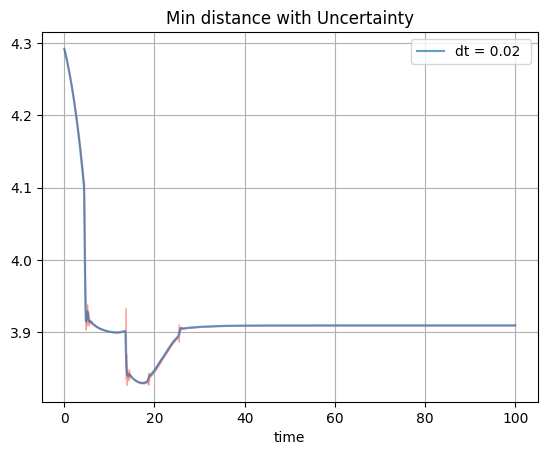

In [86]:
#GCI

u1=results[dts[0]][4]
u2=results[dts[1]][4]

x_axis_u1=results[dts[0]][3]
x_axis_u2=results[dts[1]][3]


u1_downsample=[u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2]

u1_downsample=np.array([u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2])
u2_downsample=np.array([u2[i] for i in range(len(x_axis_u2)) if x_axis_u2[i] in x_axis_u2])


# GCI
fs=3.
node_i=0
error_gci=np.abs(u1_downsample-u2_downsample)
error_gci=error_gci* fs/(np.power(2,0.5)-1.)
print(np.max(error_gci))

# plot error_gci as band
plt.fill_between(x_axis_u2, u1_downsample-error_gci,
                u1_downsample+error_gci, alpha=0.3, color='r')
plt.plot(x_axis_u2,u1_downsample,label=f'dt = 0.02 ', alpha=0.7)
plt.legend()
plt.title('Min distance with Uncertainty')
plt.xlabel('time')
plt.grid()
# plt.xlim([0,6])
plt.savefig('./plots/de_gci_min_dist.png',dpi=300, bbox_inches='tight')


In [109]:
340*0.04
error_gci[340:430]

array([4.65924654e-02, 3.51111337e-02, 2.12202815e-02, 7.58023291e-03,
       3.28757366e-03, 2.00093233e-02, 1.84577638e-02, 1.14201972e-02,
       3.42821807e-03, 3.89707680e-03, 3.68238169e-03, 5.35243419e-03,
       4.79222549e-03, 2.46982573e-03, 7.55138226e-04, 3.93144508e-03,
       6.27766652e-03, 7.34619333e-03, 7.06932654e-03, 5.70163211e-03,
       3.69571982e-03, 1.55671166e-03, 2.84469686e-04, 1.55269219e-03,
       2.15578754e-03, 2.16326846e-03, 1.75278262e-03, 1.14440676e-03,
       5.41028112e-04, 8.72603297e-05, 1.48047676e-04, 1.67456368e-04,
       2.51994665e-05, 1.99452766e-04, 4.27751790e-04, 6.00238615e-04,
       6.86057663e-04, 6.83060323e-04, 6.11052301e-04, 5.01553515e-04,
       3.87396275e-04, 2.94667582e-04, 2.38298843e-04, 2.21405472e-04,
       2.37564810e-04, 2.74736296e-04, 3.19476524e-04, 3.60382997e-04,
       3.90160640e-04, 4.06188333e-04, 4.09848329e-04, 4.05103462e-04,
       3.96855966e-04, 3.89531503e-04, 3.86160765e-04, 3.88040884e-04,
      

In [72]:
fig,axs = plt.subplots(1,1,figsize=(8,5))
axs = np.ravel(axs)
node_i=0
loop=0
for dt in results:
    if loop<2:
        diff_history,u_history,state_history, x_axis=results[dt]
        axs[0].plot(x_axis,np.linalg.norm(state_history[:,node_i,2:],axis=1),label=f'velocity norm {node_i} at dt={dt}', alpha=0.7, linestyle='--')
    loop+=1
    #plot with dash line style
# Richardson extrapolation
u1=results[dts[0]][2]
u2=results[dts[1]][2]
u3=results[dts[2]][2]

x_axis_u1=results[dts[0]][3]
x_axis_u2=results[dts[1]][3]
x_axis_u3=results[dts[2]][3]


# need to downsample u1 so u1 and u2 has the same length
u1_downsample=[u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2]
u_bar=u1_downsample+(u1_downsample-u2)/3.0
#plot u_bar
axs[0].plot(x_axis_u2,np.linalg.norm(u_bar[:,node_i,2:],axis=1),label=f'velocity norm {node_i} at standard extrapolation', alpha=1, linestyle='dotted',linewidth=4.0)

axs[0].legend()
axs[0].set_title('velocity norm')
plt.xlabel('iterations')
axs[0].set_ylabel('velocity norm')
axs[0].grid()

plt.savefig('./plots/de_extrapolation.png',dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 800x500 with 0 Axes>

In [98]:
node_i=0
# Richardson extrapolation
u1=results[dts[0]][2]
u2=results[dts[1]][2]

x_axis_u1=results[dts[0]][3]
x_axis_u2=results[dts[1]][3]


# u1_downsample=[u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2]

u1_downsample=np.array([u1[i] for i in range(len(x_axis_u1)) if x_axis_u1[i] in x_axis_u2])
u2_downsample=np.array([u2[i] for i in range(len(x_axis_u2)) if x_axis_u2[i] in x_axis_u2])

0.4363551229849578


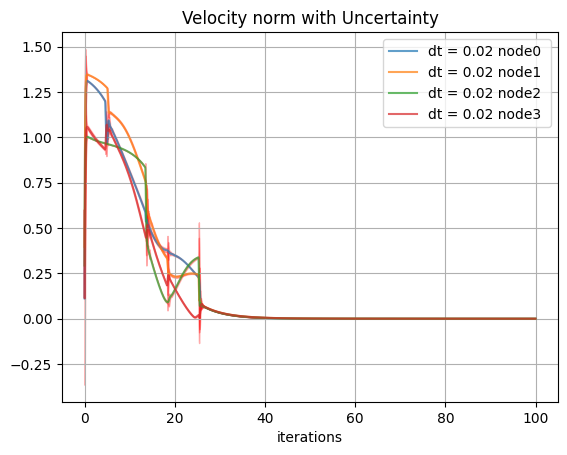

In [106]:
#GCI
# GCI
fs=3.
node_i=0
error_gci=np.abs(u1_downsample-u2_downsample)
error_gci=error_gci* fs/(np.power(2,0.5)-1.)
print(np.max(np.linalg.norm(error_gci[:,node_i,2:],axis=1)))
for node_i in range(4):
# plot error_gci as band
    plt.fill_between(x_axis_u2, np.linalg.norm(u1_downsample[:,node_i,2:],axis=1)-np.linalg.norm(error_gci[:,node_i,2:],axis=1),
                    np.linalg.norm(u1_downsample[:,node_i,2:],axis=1)+np.linalg.norm(error_gci[:,node_i,2:],axis=1), alpha=0.3, color='r')
    plt.plot(x_axis_u2,np.linalg.norm(u1_downsample[:,node_i,2:],axis=1),label=f'dt = 0.02 node{node_i} ', alpha=0.7)
plt.legend()
plt.title('Velocity norm with Uncertainty')
plt.xlabel('iterations')
plt.grid()
# plt.xlim([0,6])
# plt.savefig('./plots/de_gci_v.png',dpi=300, bbox_inches='tight')


0.0873612924284216


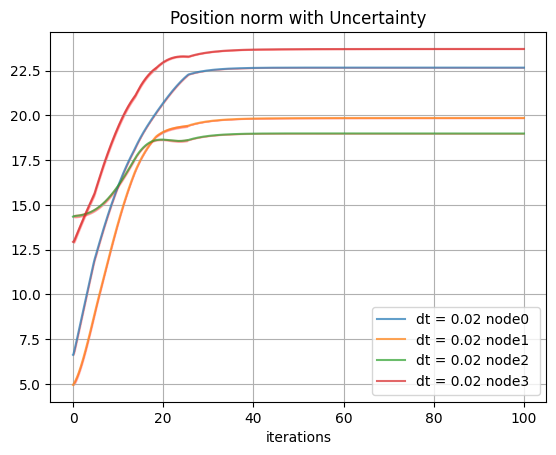

In [107]:
#GCI
# GCI
fs=3.
node_i=0
error_gci=np.abs(u1_downsample-u2_downsample)
error_gci=error_gci* fs/(np.power(2,0.5)-1.)
print(np.max(np.linalg.norm(error_gci[:,node_i,:2],axis=1)))
for node_i in range(4):
# plot error_gci as band
    plt.fill_between(x_axis_u2, np.linalg.norm(u1_downsample[:,node_i,:2],axis=1)-np.linalg.norm(error_gci[:,node_i,:2],axis=1),
                    np.linalg.norm(u1_downsample[:,node_i,:2],axis=1)+np.linalg.norm(error_gci[:,node_i,:2],axis=1), alpha=0.3, color='r')
    plt.plot(x_axis_u2,np.linalg.norm(u1_downsample[:,node_i,:2],axis=1),label=f'dt = 0.02 node{node_i} ', alpha=0.7)
plt.legend()
plt.title('Position norm with Uncertainty')
plt.xlabel('iterations')
plt.grid()
# plt.xlim([0,6])
# plt.savefig('./plots/de_gci_p.png',dpi=300, bbox_inches='tight')


In [94]:
error_gci_norm=np.linalg.norm(error_gci[:,node_i,2:],axis=1)[:]
print(error_gci_norm[340:343])
print(error_gci_norm[376])



[0.13452647 0.18539773 0.19408514]
0.009472426489302816


In [112]:
x=0.04
type(x)
# x=np.array([1.0])
# type(x.dtype)

float

In [95]:
#find the 10 maximum error in error_gci_norm
max_error_index=np.argsort(error_gci_norm)[-10:]
print(max_error_index)
print(error_gci_norm[max_error_index])

[  7 343 341   6 342   5   4   1   3   2]
[0.14022897 0.15686467 0.18539773 0.19384306 0.19408514 0.26041651
 0.33581634 0.3518115  0.40599301 0.43635512]


/tmp/ipykernel_2206826/1749189630.py:5: RuntimeWarning: invalid value encountered in divide
  p=np.log(error_u3_v/error_u2_v)/np.log(2)


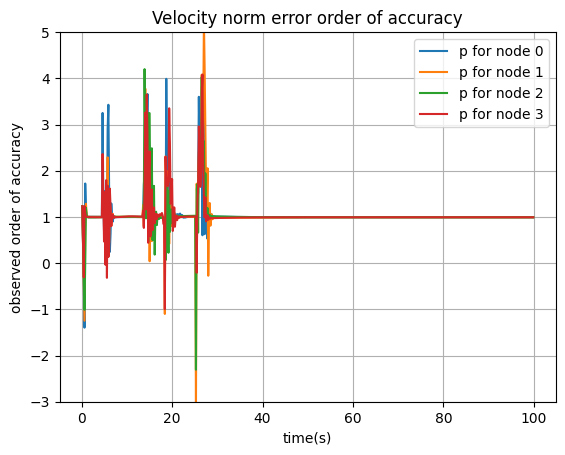

In [40]:
error_u2_v=np.linalg.norm(error_u2[:,:,2:],axis=2)
error_u3_v=np.linalg.norm(error_u3[:,:,2:],axis=2)
error_u4_v=np.linalg.norm(error_u4[:,:,2:],axis=2)

p=np.log(error_u3_v/error_u2_v)/np.log(2)
plt.plot(x_axis_u4,p[:,0],label='p for node 0')
plt.plot(x_axis_u4,p[:,1],label='p for node 1')
plt.plot(x_axis_u4,p[:,2],label='p for node 2')
plt.plot(x_axis_u4,p[:,3],label='p for node 3')
plt.ylim([-3,5])
plt.yticks(np.arange(-3,6,1))
plt.legend()
plt.ylabel('observed order of accuracy')
plt.xlabel('time(s)')
plt.title('Velocity norm error order of accuracy')
plt.grid()
plt.savefig('./plots/de_order_of_accuracy_velocity.png',dpi=300, bbox_inches='tight')


/tmp/ipykernel_2206826/2527213358.py:5: RuntimeWarning: invalid value encountered in divide
  p=np.log(error_u3_v/error_u2_v)/np.log(2)


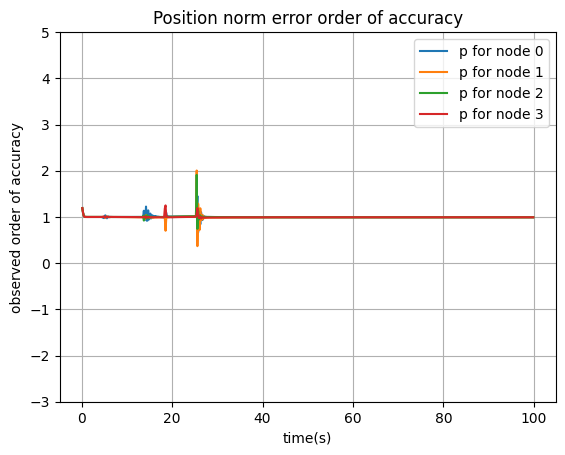

In [39]:
error_u2_v=np.linalg.norm(error_u2[:,:,:2],axis=2)
error_u3_v=np.linalg.norm(error_u3[:,:,:2],axis=2)
error_u4_v=np.linalg.norm(error_u4[:,:,:2],axis=2)

p=np.log(error_u3_v/error_u2_v)/np.log(2)
plt.plot(x_axis_u4,p[:,0],label='p for node 0')
plt.plot(x_axis_u4,p[:,1],label='p for node 1')
plt.plot(x_axis_u4,p[:,2],label='p for node 2')
plt.plot(x_axis_u4,p[:,3],label='p for node 3')
plt.ylim([-3,5])
plt.yticks(np.arange(-3,6,1))
plt.legend()
plt.ylabel('observed order of accuracy')
plt.xlabel('time(s)')
plt.title('Position norm error order of accuracy')
plt.grid()
plt.savefig('./plots/de_order_accuracy_position.png', dpi=300, bbox_inches='tight')


In [106]:
# load results data
TIMES_OUTTER = 100
TIMES_INNER = 100
ts=13.6

results_min_distance = np.load(f'./data/results_min_distance_sim{TIMES_OUTTER}_{TIMES_INNER}_{ts}.npy')
results_velocity_diff_max = np.load(f'./data/results_velocity_diff_max_sim{TIMES_OUTTER}_{TIMES_INNER}_{ts}.npy')
result_A=np.load(f'./data/results_min_distance_sim1_1000_{ts}_Aonly.npy')

In [107]:
from scipy import stats

res0 = stats.ecdf(results_min_distance[0])
quantiles_le=res0.cdf.quantiles
probabilities_le=np.array(res0.cdf.probabilities)
quantiles_ge=res0.cdf.quantiles
probabilities_ge=np.array(res0.cdf.probabilities)

for i in range(results_min_distance.shape[0]):
    res1 = stats.ecdf(results_min_distance[i])
    quantiles1=res1.cdf.quantiles
    probabilities1=res1.cdf.probabilities
    quantiles_le=[ quantiles_le[i] if quantiles_le[i] < quantiles1[i] else quantiles1[i] for i in range(len(res0.cdf.quantiles))]
    probabilities_le=[ probabilities_le[i] if probabilities_le[i] < probabilities1[i] else probabilities1[i] for i in range(len(res0.cdf.probabilities))]
    quantiles_ge=[ quantiles_ge[i] if quantiles_ge[i] > quantiles1[i] else quantiles1[i] for i in range(len(res0.cdf.quantiles))]
    probabilities_ge=[ probabilities_ge[i] if probabilities_ge[i] > probabilities1[i] else probabilities1[i] for i in range(len(res0.cdf.probabilities))]


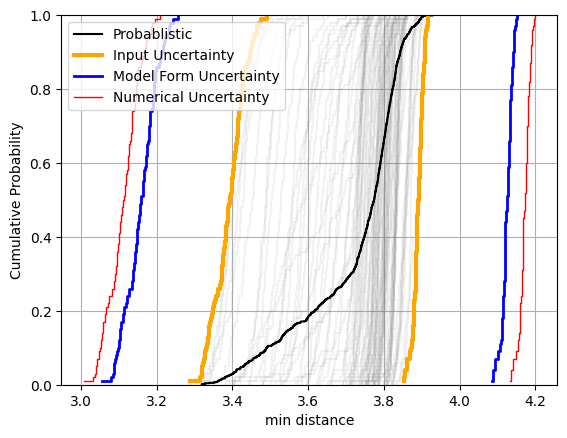

In [110]:

avm=0.234
gci=0.047
quantiles_le=np.array(quantiles_le)
quantiles_ge=np.array(quantiles_ge)

# plot results
plt.figure()
for i in range(100):
    plt.ecdf(results_min_distance[i],alpha=0.1,c='gray')
# plt.ecdf(result_le,c='black')
# plt.ecdf(result_he, c='black')
plt.ecdf(result_A[0], label='Probablistic',c='black')
plt.plot(quantiles_le,probabilities_le, drawstyle='steps-post',c='orange',label='Input Uncertainty',linewidth=3)
plt.plot(quantiles_ge,probabilities_ge, drawstyle='steps-post',c='orange',linewidth=3)

plt.plot(quantiles_le-avm,probabilities_le, drawstyle='steps-post',c='blue',linewidth=2, label='Model Form Uncertainty')
plt.plot(quantiles_ge+avm,probabilities_ge, drawstyle='steps-post',c='blue',linewidth=2, )
plt.plot(quantiles_le-avm-gci,probabilities_le, drawstyle='steps-post',c='red', label='Numerical Uncertainty', linewidth=1,)
plt.plot(quantiles_ge+avm+gci,probabilities_ge, drawstyle='steps-post',c='red',linewidth=1,)
plt.legend()
plt.grid()
plt.xlabel('min distance')
plt.ylabel('Cumulative Probability')
plt.savefig('./plots/predict_uncertainty_13.6.png',dpi=300, bbox_inches='tight')

In [79]:
14/0.04


350.0

(3.839307641193382, 0.2387279017887035)

<Figure size 640x480 with 0 Axes>

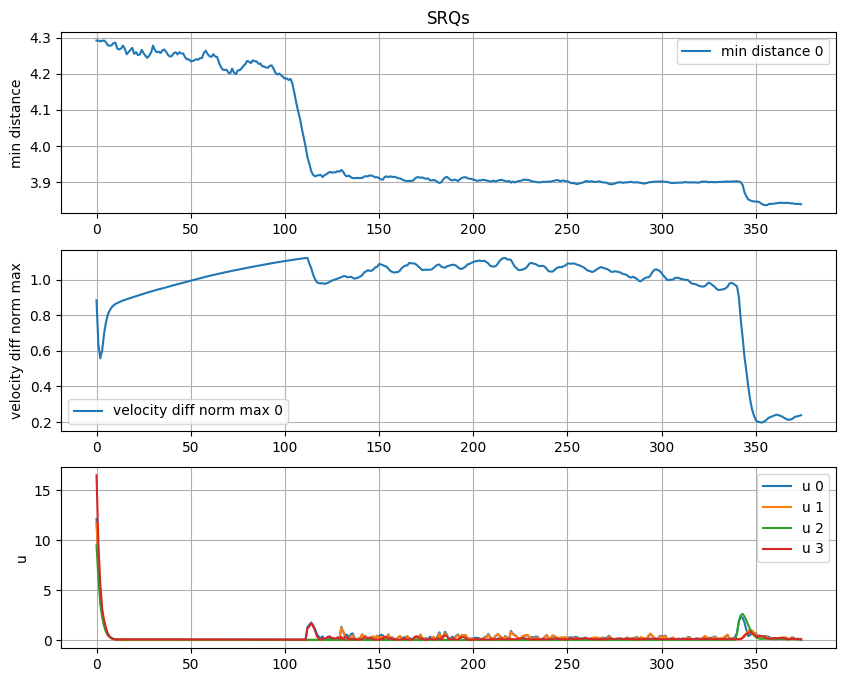

In [3]:
x_init=np.load('./data/x_init.npy')
one_simulation_hw5(noise=0, fix_seed=False, simulation_sec=15, save_fig=True,x_init=x_init,u_noise=0,dt_noise=0.004
)



Text(0.5, 1.0, 'Noise (LHS)')

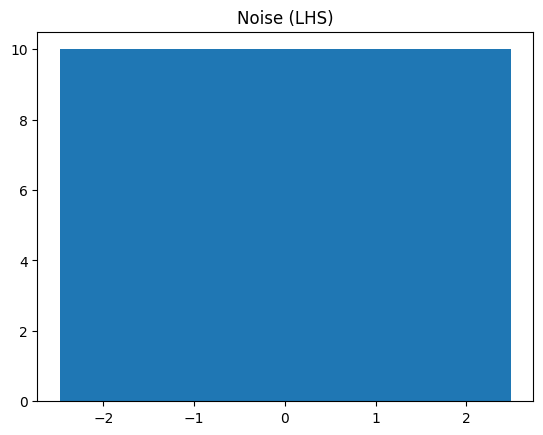

In [129]:
# noises
TIMES_OUTTER = 100
obs_noise=lhsmdu.sample(1,TIMES_OUTTER)-0.5
obs_noise=(np.array(obs_noise)*5).flatten() # 
plt.hist(obs_noise,bins=10)
plt.title('Noise (LHS)')


Text(0.5, 1.0, 'Noise (MC)')

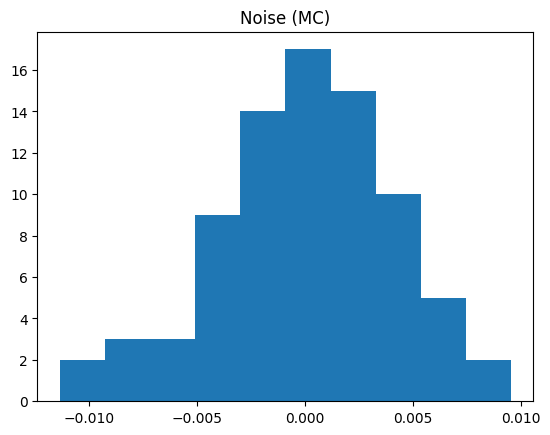

In [140]:
u_noise=np.random.normal(0,0.004,(n_agents,20)).flatten()
# plot the distribution of obs+noise
plt.hist(u_noise,bins=10)
plt.title('Noise (MC)')



In [34]:
x = np.array([2,4,8,12,16,20])
y=[]
for n_agents in x:
    #  fix the random seed
    # initialize
    np.random.seed(0)
    nx_system=4
    dt=0.04
    initial_sep=3.1
    random_init_position_range=40
    total_time=100.

    # define destination
    Destination=(150,150,0,0)
    u_gamma_position=1.
    u_gamma_velocity=1.0
    r_scale=4.0
    base=1.0
    u_scale=10.0


    valid_init=False
    while not valid_init:
        x_init=init(n_agents,nx_system, type='random')
        x_init[:,:2]=x_init[:,:2]*random_init_position_range
        # check if the initial condition is valid
        
        valid_init=True
        for i in range(n_agents):
            for j in range(i+1,n_agents):
                # for each pair of agents, check if the initial separation is valid
                if np.linalg.norm(x_init[i,:2]-x_init[j,:2])<initial_sep:
                    valid_init=False
                    random_init_position_range+=1
                    break

    min_dist,_=one_simulation_hw5(noise=0, fix_seed=True, save_fig=False, simulation_sec=50, x_init=x_init, u_noise=0, dt_noise=0)
    y.append(min_dist)


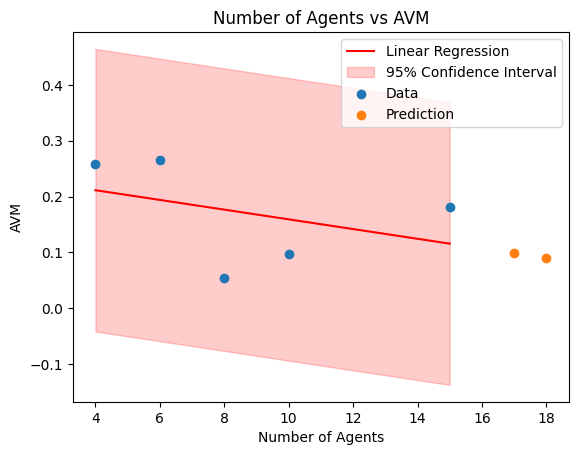

In [37]:
#linear fit x and y
x=np.array([4, 6, 8,10, 15])
y=np.array([0.2580777613030263, 0.26609705496557967, 0.054318782854743085, 0.09764167819183273, 0.18056911356208577])
a,b=np.polyfit(x,y,1)
# 95% confidence interval
x_pred=np.array([17,18])
y_oor=a*x_pred+b
y_pred = a * x + b
res = y - y_pred
std_err = np.sqrt(np.sum(res**2)/(len(res)-2))
t = 2.26
std_err = std_err*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2))
ci = t*std_err
plt.plot(x, y_pred, color='red',label='Linear Regression')
plt.fill_between(x, y_pred - ci, y_pred + ci, color='red', alpha=0.2,label='95% Confidence Interval')
plt.scatter(x,y,label='Data')
plt.scatter(x_pred,y_oor,label='Prediction')
plt.xlabel('Number of Agents')
plt.ylabel('AVM')
plt.legend()
plt.title('Number of Agents vs AVM')
plt.savefig('./plots/number_agents_vs_AVM.png',dpi=300, bbox_inches='tight')

In [38]:
y_oor

array([0.09828204, 0.08958456])

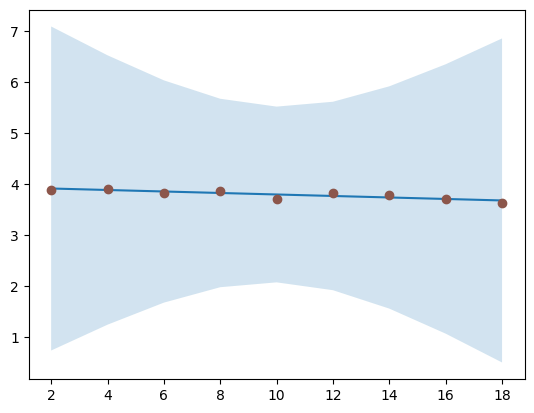

In [16]:
# x_pred=np.array([])
# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')


In [18]:
import statsmodels.api as sm

# xs = [  34,   9,  78,  60,  22,  45,  83,  59,  25 ]
# ys = [ 126, 347, 298, 309, 450, 187, 266, 385, 400 ]

xs = sm.add_constant( x )
model = sm.OLS( y, xs )
results = model.fit()
results.conf_int( alpha=0.05 )


array([[ 3.85501843,  4.03253695],
       [-0.02252807, -0.00675514]])

<Figure size 640x480 with 0 Axes>

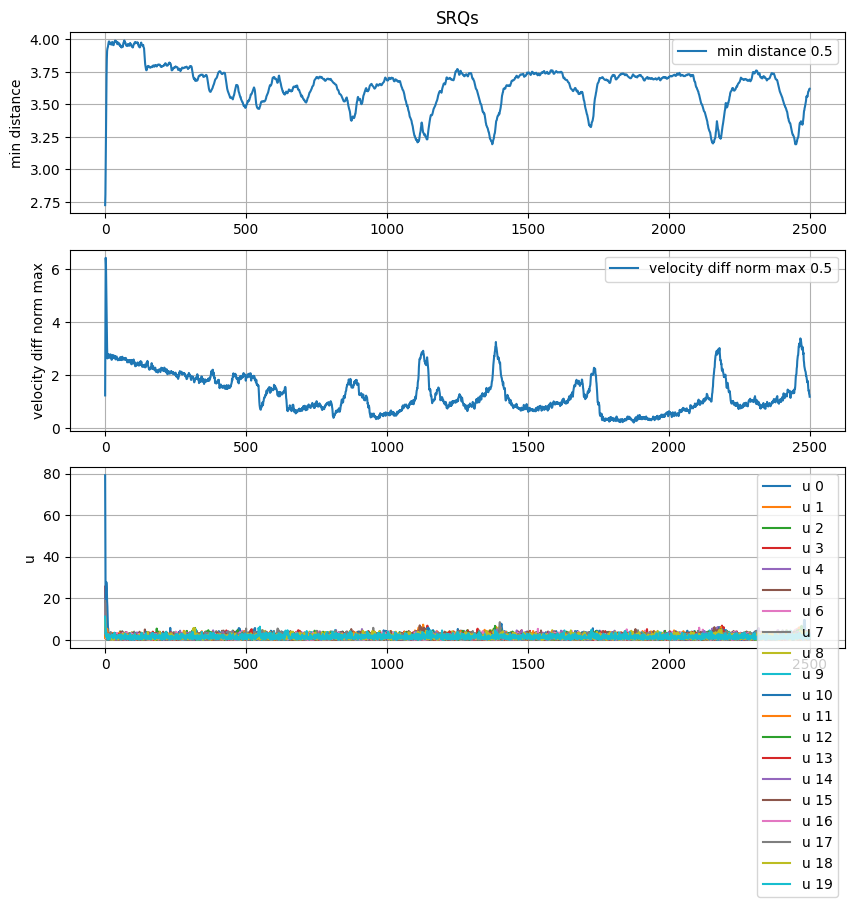

In [41]:
min_dist_srq, velocity_diff_max_srq = one_simulation_hw5(noise=0.5, fix_seed=False, simulation_sec=100, save_fig=True,x_init=x_init,u_noise=1.0,dt_noise=0.004)
        